In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [2]:
import seaborn as sn

In [3]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('opsdb/baseline2018a.db')
opsdb_pontus = db.OpsimDatabase('opsdb/pontus_2573.db')

# output directory
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)

## get some data for test

In [2]:
class getDataMetric(metrics.BaseMetric):
    """
    returns needed data 
    """
    
    def __init__(self, colname=['airmass', 'expMJD'], dataout=True, returnIdx=1, **kwargs):
        self.colname = colname
        self.returnIdx = returnIdx
        self.dataout = dataout
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
        
        
    def run(self, dataSlice, slicePoint=None):
        
        # return dataSlice directly
        if self.dataout:
            result = dataSlice
            return result
        else:
            result = np.mean(dataSlice[self.colname[int(self.returnIdx)]])
            return float(result)


In [127]:
# run the metric

metric = getDataMetric(colname=['observationStartMJD', 'fiveSigmaDepth', 'filter'])

# ra,dec of ipix 
ra = np.array([255.9375])
dec = np.array([0.0])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600 and proposalId=3'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()


Querying database SummaryAllProps with constraint night<600 and proposalId=3 for columns ['observationStartMJD', 'fieldRA', 'filter', 'fiveSigmaDepth', 'fieldDec']
Found 312003 visits
Running:  ['metricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


## test the phase space metric 

In [128]:
dataSlice = metricSky.metricValues[0]
dataSlice.sort(order='observationStartMJD')


In [ ]:
def fmatric(dataSlice):
    df = pd.DataFrame(dataSlice)
    # calculate diff
    dt = np.diff(df['observationStartMJD']) # in days
    # drop the first one
    newdf = df.drop(df.index[0])
    newdf['dt'] = dt

    # select dt > dt_input
    dt_in = 1.5/24
    df2 = newdf[newdf.dt < dt_in]
    df1 = df.loc[df2.index-1]

    df1 = df1.reset_index(drop=True) 
    df2 = df2.reset_index(drop=True) 

    df_output = pd.DataFrame()
    df_output[['t1', 'f1']] = df1[['observationStartMJD', 'filter']]
    df_output[['t2', 'f2', 'dt']] = df2[['observationStartMJD', 'filter', 'dt']]

    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

    fmatric = np.zeros((len(fdict), len(fdict)))
    f1 = df_output.f1.values
    f2 = df_output.f2.values
    for i in range(len(f1)):
        fmatric[fdict[f1[i]], fdict[f2[i]]] +=1
    


In [153]:
df = pd.DataFrame(dataSlice)
# calculate diff
dt = np.diff(df['observationStartMJD']) # in days
# drop the first one
newdf = df.drop(df.index[0])
newdf['dt'] = dt

# select dt > dt_input
dt_in = 1.5/24
df2 = newdf[newdf.dt < dt_in]
df1 = df.loc[df2.index-1]

df1 = df1.reset_index(drop=True) 
df2 = df2.reset_index(drop=True) 

df_output = pd.DataFrame()
df_output[['t1', 'f1']] = df1[['observationStartMJD', 'filter']]
df_output[['t2', 'f2', 'dt']] = df2[['observationStartMJD', 'filter', 'dt']]


In [148]:
flt = ['u', 'g', 'r', 'i', 'z', 'y']
fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

fmatric = np.zeros((len(fdict), len(fdict)))
f1 = df_output.f1.values
f2 = df_output.f2.values
for i in range(len(f1)):
    fmatric[fdict[f1[i]], fdict[f2[i]]] +=1


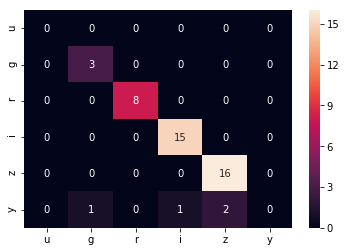

In [150]:
sn.heatmap(fmatric,annot=True, xticklabels=flt, yticklabels=flt)



In [158]:
newdf.describe()

,observationStartMJD,fieldRA,fiveSigmaDepth,fieldDec,dt
count,127.000000,1.270000e+02,127.000000,127.000000,127.000000
mean,60197.614016,2.567437e+02,22.981658,-0.279719,3.352700
std,146.450958,8.560281e-13,0.919016,0.000000,15.698669
min,60030.400613,2.567437e+02,21.253585,-0.279719,0.011667
25%,60076.271319,2.567437e+02,22.189439,-0.279719,0.021476
50%,60143.112234,2.567437e+02,22.970156,-0.279719,0.984919
75%,60394.793125,2.567437e+02,23.731753,-0.279719,1.985422
max,60451.204433,2.567437e+02,24.592539,-0.279719,174.423218


In [159]:
df

,observationStartMJD,fieldRA,filter,fiveSigmaDepth,fieldDec
0,60025.411539,256.743676,r,24.336226,-0.279719
1,60030.400613,256.743676,y,22.458489,-0.279719
2,60031.396019,256.743676,i,23.875053,-0.279719
3,60033.377095,256.743676,z,23.484934,-0.279719
4,60033.402662,256.743676,z,23.406924,-0.279719
5,60035.377593,256.743676,y,22.140343,-0.279719
6,60036.383194,256.743676,z,23.162143,-0.279719
7,60036.399873,256.743676,z,23.328870,-0.279719
8,60037.378102,256.743676,g,24.361119,-0.279719
9,60037.391910,256.743676,g,24.226223,-0.279719


In [155]:
newdf

,observationStartMJD,fieldRA,filter,fiveSigmaDepth,fieldDec,dt
1,60030.400613,256.743676,y,22.458489,-0.279719,4.989074
2,60031.396019,256.743676,i,23.875053,-0.279719,0.995405
3,60033.377095,256.743676,z,23.484934,-0.279719,1.981076
4,60033.402662,256.743676,z,23.406924,-0.279719,0.025567
5,60035.377593,256.743676,y,22.140343,-0.279719,1.974931
6,60036.383194,256.743676,z,23.162143,-0.279719,1.005602
7,60036.399873,256.743676,z,23.328870,-0.279719,0.016678
8,60037.378102,256.743676,g,24.361119,-0.279719,0.978229
9,60037.391910,256.743676,g,24.226223,-0.279719,0.013808
10,60047.344074,256.743676,i,23.730299,-0.279719,9.952164


### run the filterStyleMetric

In [4]:
from mycode.filterStyleMetric import filterStyleMetric

In [5]:
# run the metric

metric = filterStyleMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['y','i'], dataout=True)

# ra,dec of ipix 
ra = np.array([255.9375])
dec = np.array([0.0])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600 and proposalId=3'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint night<600 and proposalId=3 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 312003 visits
Running:  ['metricSky']
calculate fmatric for y i
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


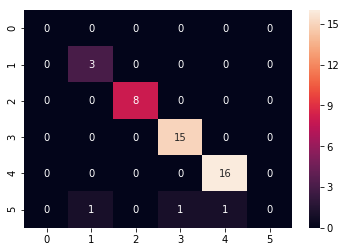

In [10]:
fmatric = metricSky.metricValues[0]
sn.heatmap(fmatric, annot=True)

In [11]:
# run the metric

metric = filterStyleMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['y','i'], dataout=False)

slicer = slicers.HealpixSlicer(nside=16)

sqlconstraint = 'night<600 and proposalId=3'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 and proposalId=3 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 312003 visits
Running:  ['metricSky']
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmat

calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fm

calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fm

calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fm

calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fm

Plotting figures with "night<600 and proposalId=3" constraint now.
monopole: 0.801301  dipole: lon: -34.3577, lat: 75.9235, amp: 0.950098
Plotting complete.


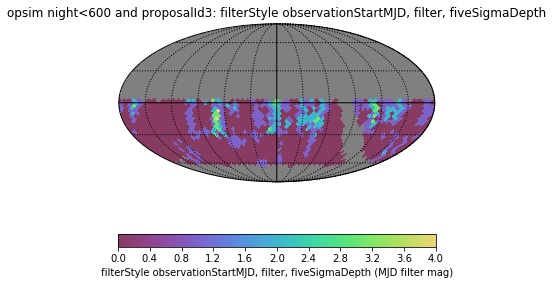

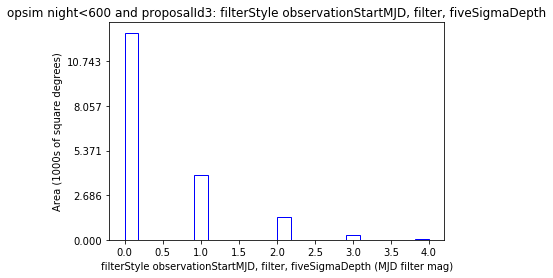

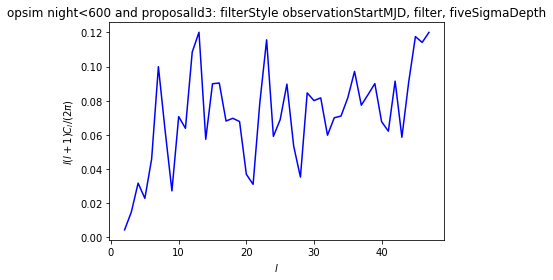

In [14]:
group.plotAll(closefigs=False)

In [15]:
# run the metric

metric = filterStyleMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['y','i'], dataout=False)

slicer = slicers.HealpixSlicer(nside=16)

sqlconstraint = 'night<600 and proposalId=3'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb_pontus, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 and proposalId=3 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 301918 visits
Running:  ['metricSky']
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmat

calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fm

calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fm

calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fm

calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fmatric for y i
calculate fm

Plotting figures with "night<600 and proposalId=3" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0321176  dipole: lon: 66.5553, lat: 11.8826, amp: 0.034869
Plotting complete.


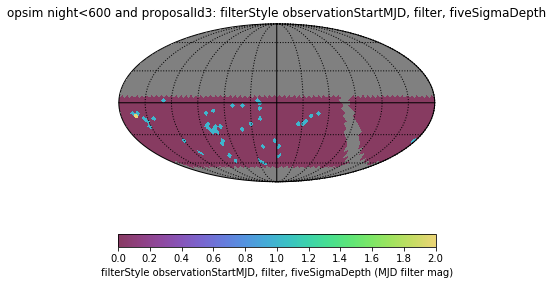

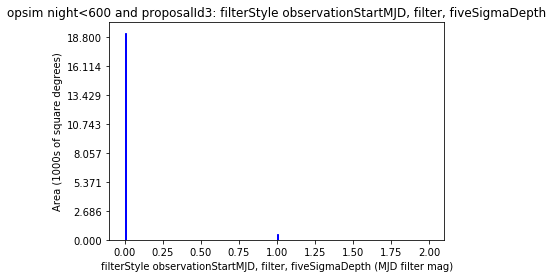

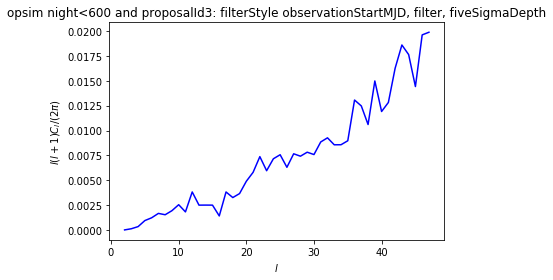

In [16]:
group.plotAll(closefigs=False)

#### for pontus

In [163]:
# run the metric

metric = getDataMetric(colname=['observationStartMJD', 'fiveSigmaDepth', 'filter'])

# ra,dec of ipix 
ra = np.array([255.9375])
dec = np.array([0.0])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600 and proposalId=3'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb_pontus, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint night<600 and proposalId=3 for columns ['observationStartMJD', 'fieldRA', 'filter', 'fiveSigmaDepth', 'fieldDec']
Found 301918 visits
Running:  ['metricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [167]:
dataSlice_pontus = metricSky.metricValues[0]
dataSlice_pontus.sort(order='observationStartMJD')

df = pd.DataFrame(dataSlice_pontus)
# calculate diff
dt = np.diff(df['observationStartMJD']) # in days
# drop the first one
newdf = df.drop(df.index[0])
newdf['dt'] = dt

# select dt > dt_input
dt_in = 1.5/24
df2 = newdf[newdf.dt < dt_in]
df1 = df.loc[df2.index-1]

df1 = df1.reset_index(drop=True) 
df2 = df2.reset_index(drop=True) 

df_output = pd.DataFrame()
df_output[['t1', 'f1']] = df1[['observationStartMJD', 'filter']]
df_output[['t2', 'f2', 'dt']] = df2[['observationStartMJD', 'filter', 'dt']]

flt = ['u', 'g', 'r', 'i', 'z', 'y']
fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

fmatric = np.zeros((len(fdict), len(fdict)))
f1 = df_output.f1.values
f2 = df_output.f2.values
for i in range(len(f1)):
    fmatric[fdict[f1[i]], fdict[f2[i]]] +=1


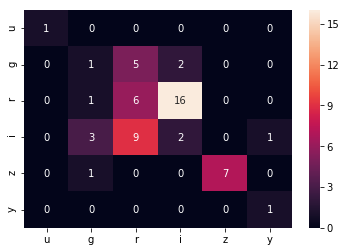

In [168]:
sn.heatmap(fmatric,annot=True, xticklabels=flt, yticklabels=flt)


In [ ]:
dt = 1.5 / 24  # 1.5 hours

def run(self, dataSlice, slicePoint=None):
    # sort dataSlice
    dataSlice.sort(order=self.mjdCol)
    
    # calculate time diff between two visits
    diff = np.diff()
    
    # find all obs diff less than dt 
    idx2 = diff < dt
    idx1 = idx-1
    
    # create a table 
    t1 = 
    t2 = 
    f1 = 
    f2 = 
    m1 = 
    m2 = 
    deltat = 
    
    
    

In [ ]:
class phspaceMetric(metrics.BaseMetric):
    """
    returns needed data 
    """
    
    def __init__(self, colname=['airmass', 'expMJD'], dataout=True, returnIdx=1, **kwargs):
        self.colname = colname
        self.returnIdx = returnIdx
        self.dataout = dataout
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
        
        
    def run(self, dataSlice, slicePoint=None):
        # sort dataSlice
        dataSlice.sort(order=self.mjdCol)
        
        # calculate time diff between two visits
        
        
        
        
        # return dataSlice directly
        if self.dataout:
            result = dataSlice
            return result
        else:
            result = np.mean(dataSlice[self.colname[int(self.returnIdx)]])
            return float(result)
